<a href="https://colab.research.google.com/github/lephuocdat2000/DeepLearning-and-Application/blob/main/SER/Combined_Eng_Vie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import scipy.io.wavfile
import numpy as np
import sys
import glob 
import librosa
import os
import matplotlib.pyplot as plt
from scipy.stats import zscore
from IPython.display import Audio
### Time Distributed ConvNet imports ###
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, TimeDistributed, concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, BatchNormalization, LeakyReLU, Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import LabelEncoder
from IPython.display import Image
from glob import glob
import pickle
import itertools
from sklearn.model_selection import train_test_split
from PIL import Image
from numpy import load
### Audioimport ###
import IPython

### Warning ###
import warnings
warnings.filterwarnings('ignore')

#Prepare Data

Load Vie-Dataset

In [3]:
vie_vie_X_test = load('/content/drive/MyDrive/Nhận dạng/vie-vie/vie_vie_X_test.npy')
vie_vie_X_train = load('/content/drive/MyDrive/Nhận dạng/vie-vie/vie_vie_X_train.npy')
vie_vie_y_test = load('/content/drive/MyDrive/Nhận dạng/vie-vie/vie_vie_y_test.npy')
vie_vie_y_train = load('/content/drive/MyDrive/Nhận dạng/vie-vie/vie_vie_y_train.npy')

Load Eng-Dataset

In [4]:
eng_vie_X_train = load('/content/drive/MyDrive/Nhận dạng/eng-vie/eng-vie_X_train.npy')
eng_vie_y_train = load('/content/drive/MyDrive/Nhận dạng/eng-vie/eng-vie_y_train.npy')

In [5]:
#Time distributed parameters
win_ts = 128
hop_ts = 64

# Split spectrogram into frames
def frame(x, win_step=128, win_size=64):
    nb_frames = 1 + int((x.shape[2] - win_size) / win_step)
    frames = np.zeros((x.shape[0], nb_frames, x.shape[1], win_size)).astype(np.float32)
    for t in range(nb_frames):
        frames[:,t,:,:] = np.copy(x[:,:,(t * win_step):(t * win_step + win_size)]).astype(np.float32)
    return frames

eng_vie_X_train = frame(eng_vie_X_train, hop_ts, win_ts)

Combine Dataset

In [6]:
X_ = np.concatenate((vie_vie_X_test,vie_vie_X_train,eng_vie_X_train))
y_ = np.concatenate((vie_vie_y_test,vie_vie_y_train,eng_vie_y_train))

#Split train and test set
X_train,X_test,y_train,y_test = train_test_split(X_,y_,test_size=0.2,random_state=42)

Encoding

In [7]:
#Encode label
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(np.ravel(y_train)))
y_test = np_utils.to_categorical(lb.transform(np.ravel(y_test)))

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] , X_train.shape[2], X_train.shape[3], 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] ,X_test.shape[2], X_test.shape[3], 1)

#Training

Define model

In [ ]:
from IPython.display import Image

K.clear_session()

# Define two sets of inputs: MFCC and FBANK
input_y = Input(shape=X_train.shape[1:], name='Input_MELSPECT')

## First LFLB (local feature learning block)
y = TimeDistributed(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same'), name='Conv_1_MELSPECT')(input_y)
y = TimeDistributed(BatchNormalization(), name='BatchNorm_1_MELSPECT')(y)
y = TimeDistributed(Activation('elu'), name='Activ_1_MELSPECT')(y)
y = TimeDistributed(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'), name='MaxPool_1_MELSPECT')(y)
y = TimeDistributed(Dropout(0.2), name='Drop_1_MELSPECT')(y)     

## Second LFLB (local feature learning block)
y = TimeDistributed(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same'), name='Conv_2_MELSPECT')(y)
y = TimeDistributed(BatchNormalization(), name='BatchNorm_2_MELSPECT')(y)
y = TimeDistributed(Activation('elu'), name='Activ_2_MELSPECT')(y)
y = TimeDistributed(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'), name='MaxPool_2_MELSPECT')(y)
y = TimeDistributed(Dropout(0.2), name='Drop_2_MELSPECT')(y)

## Second LFLB (local feature learning block)
y = TimeDistributed(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same'), name='Conv_3_MELSPECT')(y)
y = TimeDistributed(BatchNormalization(), name='BatchNorm_3_MELSPECT')(y)
y = TimeDistributed(Activation('elu'), name='Activ_3_MELSPECT')(y)
y = TimeDistributed(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'), name='MaxPool_3_MELSPECT')(y)
y = TimeDistributed(Dropout(0.2), name='Drop_3_MELSPECT')(y)

## Second LFLB (local feature learning block)
y = TimeDistributed(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same'), name='Conv_4_MELSPECT')(y)
y = TimeDistributed(BatchNormalization(), name='BatchNorm_4_MELSPECT')(y)
y = TimeDistributed(Activation('elu'), name='Activ_4_MELSPECT')(y)
y = TimeDistributed(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'), name='MaxPool_4_MELSPECT')(y)
y = TimeDistributed(Dropout(0.2), name='Drop_4_MELSPECT')(y)  

## Flat
y = TimeDistributed(Flatten(), name='Flat_MELSPECT')(y)                      
                               
# Apply 2 LSTM layer and one FC
y = LSTM(256, return_sequences=False, dropout=0.2, name='LSTM_1')(y)
y = Dense(y_train.shape[1], activation='softmax', name='FC')(y)

# Build final model
model = Model(inputs=input_y, outputs=y)

# Plot model graph
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
Image(retina=True, filename='model.png')

In [10]:
cd /content/drive/MyDrive/Nhận dạng/combined_model

/content/drive/MyDrive/Nhận dạng/combined_model


In [ ]:
# Compile model
model.compile(optimizer=SGD(lr=0.01, decay=1e-6, momentum=0.8), loss='categorical_crossentropy', metrics=['accuracy'])

# Save best model
best_model_save = ModelCheckpoint('weights.{epoch:02d}-{val_loss:.2f}.h5', save_best_only=True, monitor='val_accuracy', mode='max')

# Early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=40, verbose=1, mode='max')

# Fit model
history = model.fit(X_train,y_train, batch_size=64, epochs=200, validation_data=(X_test, y_test), callbacks=[early_stopping, best_model_save])

Compile

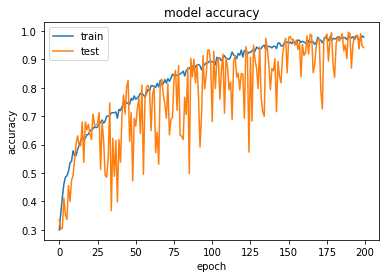

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#Predict

Function

In [25]:
sample_rate = 16000     
max_pad_len = 49100

def mel_spectrogram(y, sr=16000, n_fft=512, win_length=256, hop_length=128, window='hamming', n_mels=128, fmax=4000):
    
    # Compute spectogram
    mel_spect = np.abs(librosa.stft(y, n_fft=n_fft, window=window, win_length=win_length, hop_length=hop_length)) ** 2
    
    # Compute mel spectrogram
    mel_spect = librosa.feature.melspectrogram(S=mel_spect, sr=sr, n_mels=n_mels, fmax=fmax)
    
    # Compute log-mel spectrogram
    mel_spect = librosa.power_to_db(mel_spect, ref=np.max)
    
    return mel_spect

def predict_emotion_from_file(model, filename, chunk_step=16000, chunk_size=49100, predict_proba=False, sample_rate=16000):
        # Read audio file
        emotion1={0:'Angry',1:'Happy',2:'Sad',3:'Neutral'}
        y, sr = librosa.core.load(filename, sr=sample_rate, offset=0.5)
        win_ts = 128
        hop_ts = 64
        if len(y) < max_pad_len:    
          y_padded = np.zeros(max_pad_len)
          y_padded[:len(y)] = y
          y = y_padded
        elif len(y) > max_pad_len:
          y = np.asarray(y[:max_pad_len])
        # Split audio signals into chunks
        chunks = frame(y.reshape(1, 1, -1), chunk_step, chunk_size)
        # Reshape chunks
        chunks = chunks.reshape(chunks.shape[1],chunks.shape[-1])

        # Z-normalization
        y = np.asarray(list(map(zscore, chunks)))

        # Compute mel spectrogram
        mel_spect = np.asarray(list(map(mel_spectrogram, y)))

        # Time distributed Framing
        mel_spect_ts = frame(mel_spect,hop_ts,win_ts)
        # Build X for time distributed CNN
        X = mel_spect_ts.reshape(mel_spect_ts.shape[0],
                                    mel_spect_ts.shape[1],
                                    mel_spect_ts.shape[2],
                                    mel_spect_ts.shape[3],
                                    1)
        # Predict emotion
        if predict_proba is True:
            predict = model.predict(X)
        else:
            predict = np.argmax(model.predict(X), axis=1)
            print(predict)
            predict = [emotion1.get(emotion) for emotion in predict]
        return predict

In [27]:
filepath = '/content/drive/MyDrive/Nhận dạng/new_data'
filenames = os.listdir(filepath)
labels = []
pred_labels = []
for name in filenames:
   print(name)
   labels.append(name[0])
   path = os.path.join(filepath,name)
   pred_labels.append(predict_emotion_from_file(model,filename=path))

1_1.wav
[1]
0_0.wav
[1]
0_1.wav
[1]
1_0.wav
[2]
2_0.wav
[1]
2_1.wav
[1]
1_2.wav
[1]
2_2.wav
[2]
